# An NLP tour in the Wonderland
### Andrew Yip
Natural Language Processing (NLP) is a fascinating field: the first gateway towards human-friendly user experience. In sci-fi movies decades before peresonal and mobile computing, we witnessed how the public vision of how we interact with intelligent machines in ways we would interact with fellow human beings. This vision is made possible today with the advances in NLP through machine learning, deep learning, and the wide adoption of conversational interface via chatbots (Messenger, Telegram, etc.) and voice assistants (Alexa, Google Assistant).

Today, we will explore a fundamental concept in NLP: Language Model. A Language Model is a probability distribution over sequences of words that affords the ability to predict the next word in the sequence. In this brief, we will build a language model via two approaches: first from scratch using a word-pair frequency approach, then with an n-gram approach to further expand the model utilizing an NLP library. Along the exploratory path, we will look at sentiments exhibited across the chapters, and uncover the relationships between the characters. We will end the tour with some practical considerations of language modeling in classification problems and their potential impacts on building Mindsphere's applications.

## The Problem
1. Create a method that calculates the frequency of word pairs in a text file.
2. Create a method that returns the word that is the most likely successor of the word that is given as a parameter.

## Data Cleaning
Before jumping onto the task of language modeling, it is imperative to inspect the data and clean it as necessary.

In [1]:
import requests

# read the text directly from the internet
response = requests.get("https://www.gutenberg.org/files/11/11-0.txt")
rawtxt = response.text

# inspect the first and last 500 characters
print(f"header>>\n{rawtxt[:500]}")
print(f"footer>>\n{rawtxt[-500:]}")

header>>
﻿Project Gutenberg’s Alice’s Adventures in Wonderland, by Lewis Carroll

This eBook is for the use of anyone anywhere at no cost and with
almost no restrictions whatsoever.  You may copy it, give it away or
re-use it under the terms of the Project Gutenberg License included
with this eBook or online at www.gutenberg.org


Title: Alice’s Adventures in Wonderland

Author: Lewis Carroll

Posting Date: June 25, 2008 [EBook #11]
Release Date: March, 1994
Last Updated: October 6, 2016

footer>>
ss a copyright notice is included.  Thus, we do not necessarily
keep eBooks in compliance with any particular paper edition.


Most people start at our Web site which has the main PG search facility:

     http://www.gutenberg.org

This Web site includes information about Project Gutenberg-tm,
including how to make donations to the Project Gutenberg Literary
Archive Foundation, how to help produce our new eBooks, and how to
subscribe to our email newsletter to hear about new eBooks.



## Preprocessing
The unicode text file is littered with eol(end-of-line) characters that should be cleaned in preprocessing. Let's look at some summary statistics of the text. Upon inspection the Project Gutenberg header and footer should be removed.

In [71]:
int_txt = rawtxt.split("*** START OF THIS PROJECT GUTENBERG EBOOK ALICE’S ADVENTURES IN WONDERLAND ***")[1].split("*** END OF THIS PROJECT GUTENBERG EBOOK ALICE’S ADVENTURES IN WONDERLAND ***")[0]
print(f"header>>{int_txt[:50]}")
print(f"footer>>{int_txt[-50:]}")

header>>










ALICE’S ADVENTURES IN WONDER
footer>>e’s Adventures in Wonderland, by Lewis Carroll




# Language Modeling
## Language Model by frequency of word pairs
Here's our first attempt at the language modeling problem in predicting the next word using frequency. First, tally all consecutive word pairs and their frequency across the whole book. Then write a function to look up a word, and give its most likely successor by frequency. The task is first accomplished from scratch without using any NLP library.

### From scratch

In [3]:
from collections import Counter
txt_vec = int_txt.lower().split()
txt_pairs = zip(txt_vec[:-1], txt_vec[1:])
cnt = Counter(txt_pairs)
def getMostLikelySuccessor(word):
    return sorted([(cnt[x], x) for x in cnt if x[0].startswith(word.lower())], reverse=True)[0][1][1]

[getMostLikelySuccessor(x) for x in ["Alice", "was", "at"]] == ["was", "a", "the"]

True

### Using NLP libraries
Next, we perform the same task then further explore the text using the textacy library, which affords convenient text preprocessing methods.

In [4]:
import textacy
doc = textacy.Doc(textacy.preprocess_text(int_txt))
bot2 = doc.to_bag_of_terms(ngrams=2, as_strings=True, normalize="lower", named_entities=False, filter_stops=False)

In [5]:
def getNextWord(word, bot, n):
    try:
        return sorted([(y, x) for x, y in bot.items() if x.startswith(word.lower())], reverse=True)[0][1].split(" ")[n-1]
    except IndexError:
        return "<EOL>"

[getNextWord(x, bot2, 2) for  x in ["Alice", "was", "at"]] == ["was", "a", "the"]

True

### Remarks
What we just built was a bigram language model based on frequency. However, bigrams are not very good in preserving word coherence in the sequence.

In [6]:
def textGen(seed, bot, m, n):
    '''seed: the first word, bot: bag of terms, m: number of words in the sequence'''
#     print("n:", n)
    result = seed.split(" ")
    seed = " ".join(result[-n+1:])
#     print("original seed:", seed)
    for i in range(m):
        if "<EOL>" not in result:
            new_word = getNextWord(seed, bot, n)
            result.append(new_word)
            if n > 2:
                seed = " ".join(result[-n+1:])
            else:
                seed = new_word
    return " ".join(result)

textGen("Alice", bot2, 10, 2)

'Alice was a the queen <EOL>'

Let's modify the current language model to include larger n-grams, say trigrams (3) and 4-gram and compare the results.

In [7]:
[f'{n}-gram: {textGen("Alice was going to", doc.to_bag_of_terms(ngrams=n, as_strings=True, normalize="lower", named_entities=False, filter_stops=False), 20, n)}' for n in range(2, 5)]
 
 

['2-gram: Alice was going to the queen <EOL>',
 '3-gram: Alice was going to begin with,’ the mock turtle said with some surprise that the was <EOL>',
 '4-gram: Alice was going to shrink any further <EOL>']

In the case of the 4-gram, it has become so restrictive (due to a large n and a relatively short story) that an original line from the book was returned.

# Exploratory Data Analysis

## Word frequency by chapter
It is often helpful to perform summary statistics to have an idea of the "shape" of the data. It is especially important to spot imbalanced classes due to data availability to avoid biases. Here we inpsect the various basic word counts in each chapter of the text. The chapters are well balanced except for a slightly shorter chapter 3 (A Caucus-Race and a Long Tale). Chapter 6 (Pig and Pepper) demonstrates a relative lack of word diversity per sentence. Curiously enough, that is the chapter where the quote "How do you know I'm mad" lives.

In [74]:
chapters = textacy.preprocess_text(int_txt).split("CHAPTER")[1:]
corp = textacy.Corpus("en", chapters)
ts = [textacy.TextStats(x) for x in corp]
basic_counts = pd.DataFrame([x.basic_counts for x in ts])
basic_counts["chapter"] = range(1, 13)
basic_counts["unique_word_ratio"] = basic_counts['n_unique_words'] / basic_counts['n_sents']
basic_counts

,n_chars,n_long_words,n_monosyllable_words,n_polysyllable_words,n_sents,n_syllables,n_unique_words,n_words,chapter,unique_word_ratio
0,8722,233,1765,63,106,2697,632,2191,1,5.962264
1,8388,218,1840,56,132,2597,633,2186,2,4.795455
2,7070,225,1396,71,119,2166,598,1739,3,5.025210
3,10709,294,2215,67,167,3318,737,2727,4,4.413174
4,9130,303,1824,101,136,2774,664,2240,5,4.882353
5,10660,333,2188,89,149,3265,726,2669,6,4.872483
6,9781,285,1910,73,172,2942,678,2381,7,3.941860
7,10638,352,2053,116,122,3211,688,2556,8,5.639344
8,9777,328,1906,77,145,2902,712,2355,9,4.910345
9,8802,315,1727,89,152,2568,627,2097,10,4.125000


## Sentiments across the chapters
Sentiment analysis concerns quantifying the polarity of emotion expressed in a text ranging from negative (-1), neutral (0), to positive (1). Subjectivity measures whether the text is objective (0) or subjective (1) with a varying degree. We will briefly explore the sentiments across the chapters using the TextBlob library, which provides a simplified interface for sentiment analysis at various levels of the text (chapter, sentence, etc.).

In [134]:
from textblob import TextBlob
tb = [TextBlob(chapter) for chapter in chapters]
sentiment = pd.DataFrame([chapter.sentiment for chapter in tb])
sentiment["chapter"] = range(1, 13)
sentiment.head()

,polarity,subjectivity,chapter
0,0.027015,0.502594,1
1,0.026922,0.511728,2
2,0.037310,0.458711,3
3,0.036413,0.501831,4
4,0.006358,0.469411,5


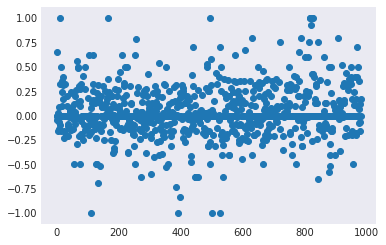

In [128]:
polarity = [sentence.sentiment.polarity for chapter in tb for sentence in chapter.sentences]
plt.scatter(x=list(range(len(polarity))), y=polarity);

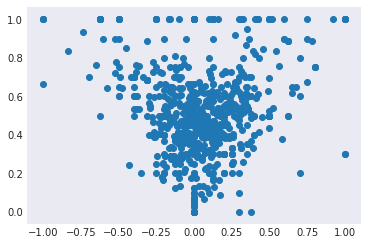

In [129]:
# relationship between subjectivity and polarity
subjectivity = [sentence.sentiment.subjectivity for chapter in tb for sentence in chapter.sentences]
plt.scatter(x=polarity, y=subjectivity);

We observe a slight positive trend in the sentiment polarity as the plot progresses. And that there's a positive correspondence between subjectivity and the magnitude in polarity.

## Characters appearance across chapters
It would be of interest correlate characters and the associated sentiment variation in the plot. A first step would be to count the character appearances per chapter. The list of characters is extracted from [this site](http://www.alice-in-wonderland.net/resources/analysis/character-descriptions/).

In [135]:
from collections import defaultdict
chars = ['alice', 'rabbit', 'caterpillar', 'cat', 'cheshire', 'queen', 'sister', 'dinah', 'mouse', 'duck', 'dodo', 'lory', 'eaglet', 'crab', 'mary', 'pat','bill', 'guinea', 'puppy', 'pigeon', 'frog-footman', 'fish-footman', 'duchess', 'baby', 'cook', 'march', 'dormouse', 'elsie', 'lacie', 'tillie', 'five', 'seven', 'two', 'knave', 'king', 'flamingos', 'grphon', 'turtle', 'juror']
char_counts = defaultdict(list)
for chapter in tb:
    for char in chars:
        char_counts[char].append(chapter.words.lemmatize().count(char))
char_counts = pd.DataFrame(char_counts)
char_counts["chapter"] = range(1, 13) 
char_counts.head()
# WIP: to collect and plot major character apperances across chapters

,alice,baby,bill,cat,caterpillar,cheshire,cook,crab,dinah,dodo,...,pigeon,puppy,queen,rabbit,seven,sister,tillie,turtle,two,chapter
0,28,0,0,5,0,0,0,0,5,0,...,0,0,0,6,0,2,0,0,2,1
1,26,0,0,8,0,0,0,0,1,1,...,0,0,0,4,1,0,0,0,1,2
2,23,0,0,2,0,0,0,2,5,12,...,0,0,0,0,0,0,0,0,1,3
3,31,0,14,0,1,0,0,0,3,0,...,0,7,0,15,0,0,0,0,4,4
4,35,0,0,0,26,0,0,0,0,0,...,12,0,0,0,0,0,0,0,3,5


## Social Network in the Wonderland
It would be very informative to visualize the characters' social network in the wonderland. Our first approach identifies and counts the cooccurrences of characters in nearby words, then computes some centrality metrics concerning the nodes that indicates their relative importance. Betweeness quantifies the number of times a node acts as a bridge along the shortest path between two other nodes. The number of cliques (or complete sub-graphs) indicate how many tightly related community a node (character) is in. The visualized graph is created using Cytoscape and is linked [here](graph.png), where the size of the node indicates the node betweeness, the size of the node label (name) indicates the number of cliques the character is in, and the thinkness of the edge indicates counts of cooccurrences.

In [75]:
import networkx as nx
g = doc.to_semantic_network()
g.remove_edges_from(g.selfloop_edges())

In [77]:
from networkx.algorithms import community
sub_g.nodes(data=True)
sub_g = g.subgraph(chars)

for node, attr in nx.betweenness_centrality(sub_g).items():
    sub_g.nodes[node]['betweeness'] = attr
    
for node, attr in nx.number_of_cliques(sub_g).items():
    sub_g.nodes[node]['n_cliques'] = attr

nx.write_graphml(sub_g, "data/sub_g_clique.graphml")

# Neural Language Model and its applications
next step: combine sentiment on character interaction to decern the relationaship between them